In [29]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Finite case
$x\in[M]$

In [30]:
M = 1000

### True function

In [31]:
_d = 10
param = np.random.uniform(size=_d) - 1/2
fmap = np.array([[(x/M)**y for y in range(_d)] for x in range(M)])
#fmap = np.random.uniform(size = (M, _d))
_f = np.matmul(fmap, param)
f = lambda x: _f[x]

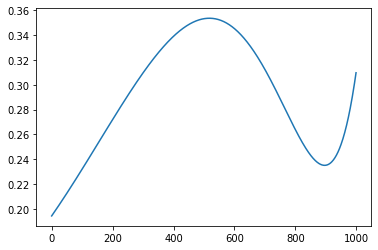

In [32]:
plt.plot(range(M), _f)

In [33]:
ylim = [min(_f)-0.1, max(_f)+0.1]

### Approximation with d random features (no noise)

In [34]:
def rfmap(d):
    return np.random.normal(size=(M,d))

In [35]:
def ols(X, y, reg=0):
    A = np.matmul(X.T,X) + reg * np.eye(d)
    b = np.matmul(X.T, y)
    theta = np.linalg.solve(A,b)
    return np.matmul(X, theta), theta

In [36]:
RF = rfmap(M)
err = np.zeros(M)
perr = np.zeros(M)
fhats = np.zeros((M,M))
for d in range(1, M+1):
    X = RF[:, :d] 
    y = _f
    fhat, theta = ols(X, y)
    fhats[d-1] = fhat
    err[d-1] = np.linalg.norm(fhat - _f, ord=1) / M
    

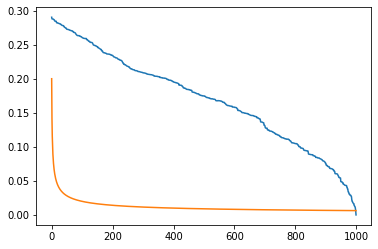

In [37]:
plt.plot(range(M), err)
plt.plot(range(M), 0.2/np.sqrt(range(1,M+1)))

In [38]:
xx = range(M)

def update(d = 1):
    plt.plot(xx, _f, xx, fhats[d-1])
    axes = plt.gca()
    axes.set_ylim(ylim)
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=M, step=1, value=1))

interactive(children=(IntSlider(value=1, description='d', max=1000, min=1), Output()), _dom_classes=('widget-i…

### With noise

In [11]:
N = 900
noise = 0.001
reg = 1
S = np.random.choice(M, size=N, replace=True)
y = _f[S] + noise * np.random.normal(size=N)

In [12]:
RF = rfmap(M)
err = np.zeros(M)
fhats = np.zeros((M,M))
for d in range(1, M+1):
    X = RF[S, :d] 
    fhat, theta = ols(X, y, reg)
    err[d-1] = np.linalg.norm(np.matmul(RF[:, :d], theta) - _f, ord=1) / N
    fhats[d-1] = np.matmul(RF[:, :d], theta)

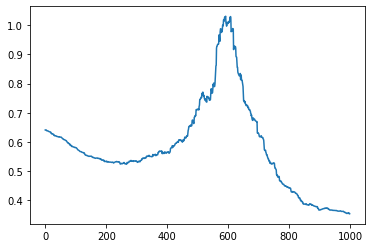

In [13]:
plt.plot(range(M), err)

In [14]:
xx = range(M)

def update(d = 1):
    plt.scatter(S,y)
    plt.plot(xx, fhats[d-1])
    axes = plt.gca()
    axes.set_ylim(ylim)
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=M, step=1, value=M))

interactive(children=(IntSlider(value=1000, description='d', max=1000, min=1), Output()), _dom_classes=('widge…

# Linear case

$x\in\mathbb{R}^m$

In [16]:
def make_fun(m):
    param = 2 * np.random.uniform(size=m) - 1
    return lambda x : np.matmul(x, param)

In [17]:
#This represents functions of the form <x,c> + d
def make_rfm(d, m):
    A = np.random.normal(size=(d, m))
    b = np.random.normal(size=d)
    return lambda X: np.matmul(A, X.T).T + b

In [18]:
def ls(A, b, reg=0):
    return np.linalg.solve(np.matmul(A.T, A) + reg * np.eye(A.shape[-1]), np.matmul(A.T, b))

In [19]:
def rf_approx(X, y, d, reg=0):
    rfm = make_rfm(d, X.shape[-1])
    Phi = rfm(X) #Nxd
    theta = ls(Phi, y, reg)
    yhat = np.matmul(Phi, theta)
    return yhat, rfm, theta

In [20]:
def gen_rank(n, m, r):
    A = 2 * np.random.uniform(size=(n, r)) - 1
    B = 2 * np.random.uniform(size=(r, r)) - 1
    C = 2 * np.random.uniform(size=(r, m)) - 1
    M = np.matmul(np.matmul(A, B), C)
    assert np.linalg.matrix_rank(M) == r
    return M

### Scalar example

(-1.0, 1.0)

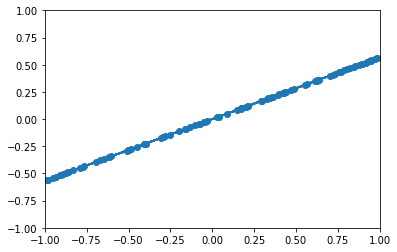

In [21]:
m = 1
N = 100
noise = 0
d = 2

f = make_fun(m)
X = 2 * np.random.uniform(size=(N, m)) - 1
y = f(X) + noise * np.random.normal(size=N)
yhat, _, _ = rf_approx(X, y, d)
xx = np.linspace(-1,1,100)
plt.scatter(X, y)
plt.plot(X, yhat)
ax = plt.gca()
ax.set_ylim([-1,1])
ax.set_xlim([-1,1])

### Full-rank case

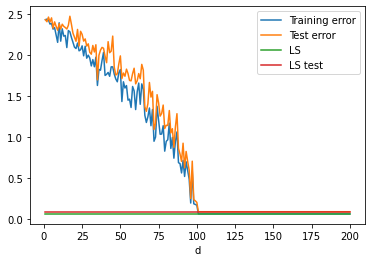

In [22]:
m = 100
N = 500
noise = 0.1
reg = 0
norm_ord = 1
max_d = 2 * m

f = make_fun(m)
X = 2 * np.random.uniform(size=(N, m)) - 1
y = f(X) + noise * np.random.normal(size=N)
ls_param = ls(X, y, reg)
yls = np.matmul(X, ls_param)
lserr = np.linalg.norm(yls - y, ord=norm_ord)**norm_ord / N
lsrank = np.linalg.matrix_rank(X)

X_test = 2 * np.random.uniform(size=(N, m)) - 1
y_test = f(X_test) + noise * np.random.normal(size=N)
yls_test = np.matmul(X_test, ls_param)
test_lserr = np.linalg.norm(yls_test - y_test, ord=norm_ord)**norm_ord / N

err = []
test_err = []
ranks = []
for d in range(1, max_d+1):
    yhat, rfm, theta = rf_approx(X, y, d, reg)
    err.append(np.linalg.norm(y - yhat, ord=norm_ord)**norm_ord / N)
    ranks.append(np.linalg.matrix_rank(rfm(X)))
    
    #Test
    yhat_test = np.matmul(rfm(X_test), theta)
    test_err.append(np.linalg.norm(y_test - yhat_test, ord=norm_ord)**norm_ord / N)

xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))

(0.0, 0.5892907877661127)

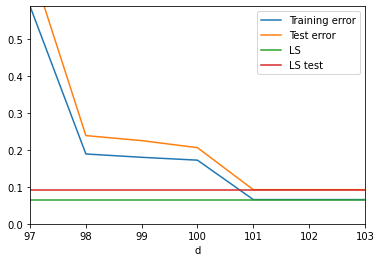

In [23]:
xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))
plt.gca().set_xlim((m-3, m+3))
plt.gca().set_ylim((0,err[m-4]))

100 101


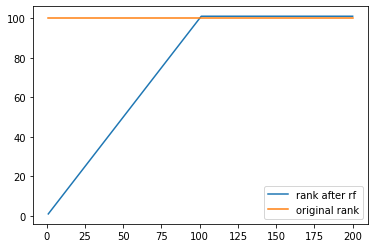

In [24]:
print(lsrank, np.max(ranks))
plt.plot(xx, ranks)
plt.plot((xx[0], xx[-1]),(lsrank, lsrank))
plt.legend(('rank after rf', 'original rank'))

In [25]:
for i in range(max_d): print(i+1, err[i], test_err[i], '\n')

1 2.4307212807176892 2.4306905262727985 

2 2.4381687134529275 2.4065006148840338 

3 2.426431465711262 2.462984677088118 

4 2.3778340042780437 2.4028918492712026 

5 2.3858603740785504 2.4532364462336407 

6 2.3160083892034047 2.3276503100737638 

7 2.3340996017659834 2.404217963527575 

8 2.2433454656156453 2.350657676627043 

9 2.155070157040972 2.3029944714518944 

10 2.393336594331811 2.3833923114324627 

11 2.169603522007288 2.3178680452334084 

12 2.3198569605944357 2.3761553017859494 

13 2.230408037547496 2.349564791999208 

14 2.2385325366910105 2.33538481347002 

15 2.091783973052863 2.317677135979732 

16 2.298800351737462 2.3622101790804817 

17 2.2836014133301195 2.4730614436603475 

18 2.2150862720682207 2.3755080819957546 

19 2.1569067180471446 2.267560686655191 

20 2.0964196741915067 2.2159017548250906 

21 2.0799773141523255 2.1680957063779225 

22 2.1465723435296193 2.3125258318787054 

23 2.0517461711710197 2.1101201386755264 

24 2.064926890517176 2.289409708075

### The rank-deficient case

97

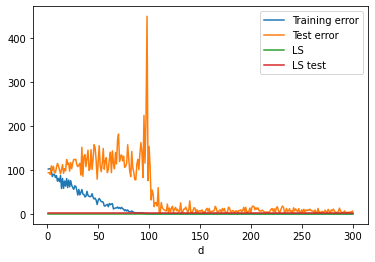

In [26]:
m = 100
N = 1000
noise = 0.1
reg = 0.1
norm_ord = 1
max_d = 3*m
rank = m - 1

f = make_fun(m)

#Contexts do not span R^d
X = gen_rank(N, m, rank)
lsrank = np.linalg.matrix_rank(X)

y = f(X) + noise * np.random.normal(size=N)
ls_param = ls(X, y, reg)
yls = np.matmul(X, ls_param)
lserr = np.linalg.norm(yls - y, ord=norm_ord)**norm_ord / N

X_test = gen_rank(N, m, rank)
y_test = f(X_test) + noise * np.random.normal(size=N)
yls_test = np.matmul(X_test, ls_param)
test_lserr = np.linalg.norm(yls_test - y_test, ord=norm_ord)**norm_ord / N

err = []
test_err = []
ranks = []
for d in range(1, max_d+1):
    yhat, rfm, theta = rf_approx(X, y, d, reg)
    err.append(np.linalg.norm(y - yhat, ord=norm_ord)**norm_ord / N)
    #print(rfm(X).shape)
    ranks.append(np.linalg.matrix_rank(rfm(X)))
    
    #Test
    yhat_test = np.matmul(rfm(X_test), theta)
    test_err.append(np.linalg.norm(y_test - yhat_test, ord=norm_ord)**norm_ord / N)

xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))
np.argmax(test_err)

99 100


Text(0.5, 0, 'd')

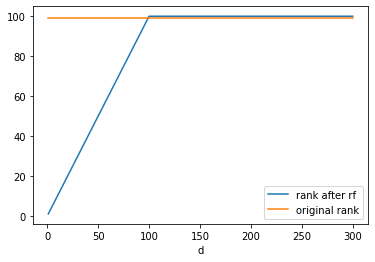

In [27]:
print(lsrank, np.max(ranks))
plt.plot(xx, ranks)
plt.plot((xx[0], xx[-1]),(lsrank, lsrank))
plt.legend(('rank after rf', 'original rank'))
plt.xlabel('d')

### Playing with perturbed matrices

In [28]:
n = 6
m = 5
r = 2
A = gen_rank(n,m,r)

B = A + np.random.normal(size=(n, m))
print(np.linalg.matrix_rank(B))

C = A + np.random.normal(size=m)
print(np.linalg.matrix_rank(C))

D = C + np.random.normal(size=m)
print(np.linalg.matrix_rank(D))

5
3
3
